# Predicting WSS in aorta using machine learning

## Packages used

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import explained_variance_score

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pickle


### WorkDir

In [3]:
work_Folder =**
work_Folder2 = **

Aorta_Metrics_file_name = 'aorta_clipped_metrics.dat'
Aorta_centerline_file_name = 'aorta_clgm.dat'
Surface_points_file_name = 'preprocessed_data_output_rescan.csv'

# full path
Metric_file_path = work_Folder + "\\" + Aorta_Metrics_file_name
Curve_file_path  = work_Folder + "\\" + Aorta_centerline_file_name
Surface_file_path = work_Folder2 + "\\" + Surface_points_file_name

### Reading the curvature metrics data

In [4]:
df_curve = pd.read_csv(Metric_file_path,
                 sep="\s+", #separator whitespace
                 header=0) 

df_cl = pd.read_csv(Curve_file_path,
                 sep="\s+", #separator whitespace
                 header=0) 

df = pd.read_csv(Surface_file_path,index_col=0)

In [5]:
df.head()

,X_SP,Y_SP,Z_SP,wall_shear,Curvature,Torsion,Area,bumpy,AngularMetric
0,0.015584,0.025652,0.057073,3.723850,14.761224,-663.715877,0.00032,0.003637,1.560743
1,0.015540,0.025508,0.057003,3.684453,14.761224,-663.715877,0.00032,0.003636,1.524686
2,0.016136,0.026722,0.057434,4.605456,14.761224,-663.715877,0.00032,0.003640,1.856349
3,0.016053,0.026561,0.057348,3.442930,14.761224,-663.715877,0.00032,0.003640,1.805955
4,0.022731,0.023138,0.061303,4.253655,14.761224,-663.715877,0.00032,0.003634,-1.199857


###  Reading the surface point data

## Exploration of the data


In [6]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,X_SP,Y_SP,Z_SP,wall_shear,Curvature,Torsion,Area,bumpy,AngularMetric
X_SP,1,0.193131,-0.213334,0.173298,-0.162055,-0.0606163,0.038513,-0.133609,-0.40502
Y_SP,0.193131,1,-0.0712737,0.329351,-0.162382,0.0548396,-0.375073,-0.809512,0.0460279
Z_SP,-0.213334,-0.0712737,1,0.162907,0.768533,0.0914532,0.0592749,0.00175629,0.0374376
wall_shear,0.173298,0.329351,0.162907,1,0.040402,0.0338181,-0.0322812,-0.272603,0.0657866
Curvature,-0.162055,-0.162382,0.768533,0.040402,1,0.0701228,0.0481859,0.149485,0.0550752
Torsion,-0.0606163,0.0548396,0.0914532,0.0338181,0.0701228,1,0.0704478,-0.0252979,0.00533485
Area,0.038513,-0.375073,0.0592749,-0.0322812,0.0481859,0.0704478,1,0.27746,0.00550172
bumpy,-0.133609,-0.809512,0.00175629,-0.272603,0.149485,-0.0252979,0.27746,1,0.0204733
AngularMetric,-0.40502,0.0460279,0.0374376,0.0657866,0.0550752,0.00533485,0.00550172,0.0204733,1


### The angularMetric is a value [-Pi, Pi], investiage if we need to take the absolute value

In [6]:
#df_abs = pd.DataFrame(df['AngularMetric'].abs())
#df_abs = df.merge(df_abs,left_index=True, right_index=True)

#corr_abs = df_abs[['MaximumInscribedSphereRadius','Curvature','Torsion','AngularMetric_y','wall_shear']].corr()
#corr_abs.style.background_gradient(cmap='coolwarm')

,MaximumInscribedSphereRadius,Curvature,Torsion,AngularMetric_y,wall_shear
MaximumInscribedSphereRadius,1,-0.257667,-0.0357288,0.00473578,-0.615658
Curvature,-0.257667,1,0.0104449,0.0499617,0.117886
Torsion,-0.0357288,0.0104449,1,0.00218273,0.00202548
AngularMetric_y,0.00473578,0.0499617,0.00218273,1,0.0666934
wall_shear,-0.615658,0.117886,0.00202548,0.0666934,1


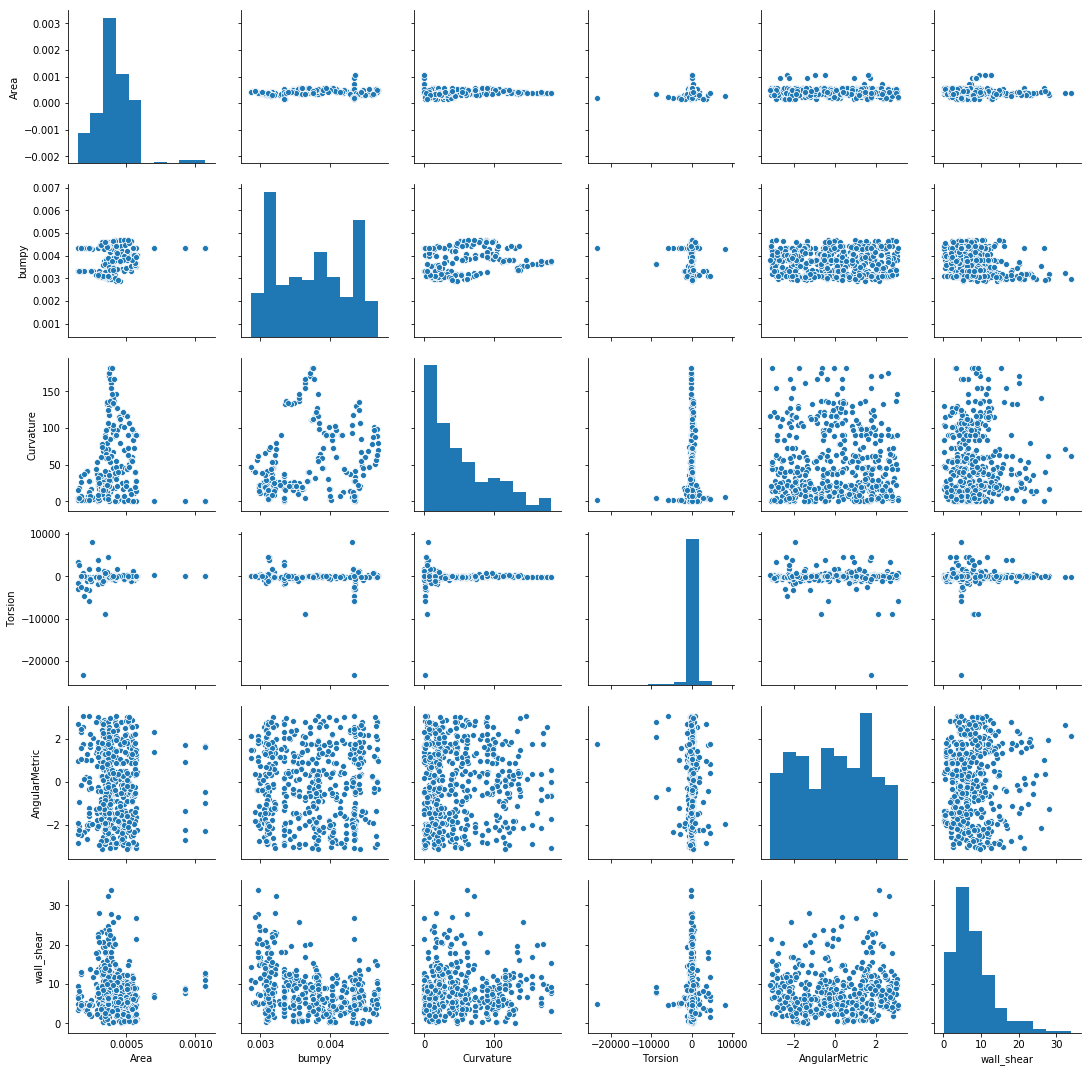

In [7]:
sns.pairplot(df[['Area','bumpy','Curvature','Torsion','AngularMetric','wall_shear']].sample(500))

In [8]:
#X = df_abs[['MaximumInscribedSphereRadius','Curvature','Torsion','AngularMetric_y']]
X = df[['Area','bumpy','Curvature','Torsion','AngularMetric']]
y = df['wall_shear']

## Data Pre-Processing

### Normalize the training data

In [9]:
transformer = Normalizer().fit(X)
X_norm = transformer.transform(X)
df_xnorm = pd.DataFrame(X_norm,columns = ['Area','bumpy','Curvature','Torsion','AngularMetric'])
df_xnorm.head()

,Area,bumpy,Curvature,Torsion,AngularMetric
0,4.812863e-07,0.000005,0.022235,-0.999750,0.002351
1,4.812864e-07,0.000005,0.022235,-0.999750,0.002297
2,4.812857e-07,0.000005,0.022235,-0.999749,0.002796
3,4.812858e-07,0.000005,0.022235,-0.999749,0.002720
4,4.812868e-07,0.000005,0.022235,-0.999751,-0.001807


### Splitting the training data

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

## Selecting amount of estimators and depth based on above analysis

In [11]:
regr = RandomForestRegressor(n_estimators = 200, max_depth=25,min_samples_split=20,min_samples_leaf=4, bootstrap = True)
regr.fit(x_train, y_train)

# save the model to disk
filename = 'RFM.sav'
pickle.dump(regr, open(work_Folder + "\\" + filename, 'wb'))

### The mean absolute error is defined as
$mae = (\frac{1}{n})\sum_{i=1}^{n}\left | y_{i} - x_{i} \right |$

In [14]:
# Use the forest's predict method on the test data
predictions = regr.predict(x_test)
#predictions_SVR = clf.predict(x_test)

print('Metrics for Random Forest and SVR Trained on Expanded Data')

# Calculate the absolute errors
errors = abs(predictions - y_test)# Print out the mean absolute error (mae)
#errors_SVR = abs(predictions_SVR - y_test)# Print out the mean absolute error (mae)

print('Mean Absolute Error_RM:', round(np.mean(errors), 2))
#print('Mean Absolute Error_SVR:', round(np.mean(errors_SVR), 2))

# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_test))
#mape_SVR = np.mean(100 * (errors_SVR / y_test))

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
#accuracy_SVR = 100 - np.mean(mape)

print('Accuracy_RM:', round(accuracy, 2), '%.')
#print('Accuracy_SVR:', round(accuracy, 2), '%.')

Metrics for Random Forest and SVR Trained on Expanded Data
Mean Absolute Error_RM: 0.94
Accuracy_RM: 85.72 %.


### Scoring

In [13]:
explained_variance_score(y_test, predictions)

0.84606191020587

In [16]:
df_res = pd.DataFrame([predictions, y_test],['predicted','test_data']).T
df_res.head()
sns.scatterplot(x=df_res['predicted'],y=df_res['test_data'])

<IPython.core.display.Javascript object>


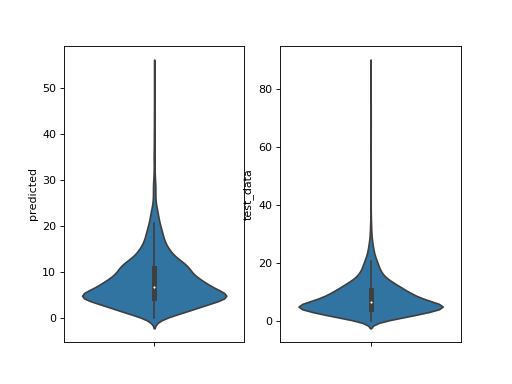

C:\Programs\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [17]:
%matplotlib notebook
plt.subplot(121)
ax = sns.violinplot(y=df_res["predicted"],bw=.2)
plt.subplot(122)
ax = sns.violinplot(y=df_res["test_data"], bw=.2)
plt.show()

In [18]:
df_res['error']=abs(df_res['predicted'] - df_res['test_data'])
df_res.head()

,predicted,test_data,error
0,11.342017,11.309982,0.032035
1,12.398158,11.807205,0.590952
2,7.951200,7.878394,0.072806
3,4.426443,4.750148,0.323705
4,5.225518,5.145451,0.080067


In [38]:
feature_rest_df =x_test

In [39]:
b=a[['wall_shear','Area','bumpy','Curvature','Torsion','Prediction WSS','Prediction error','AngularMetric']]


In [34]:
a

,index,X_SP,Y_SP,Z_SP,wall_shear,Curvature,Torsion,Area,Prediction error,Prediction WSS,bumpy,AngularMetric
0,102231,0.018473,0.032496,0.087848,11.309982,166.713936,-115.498449,0.000410,0.032035,11.342017,0.003766,3.061324
1,83392,0.017693,0.038742,0.069793,11.807205,13.772508,395.131864,0.000365,0.590952,12.398158,0.002991,-2.590723
2,92627,0.009925,0.021617,0.083369,7.878394,48.268503,-412.845365,0.000320,0.072806,7.951200,0.004475,1.053637
3,375,0.015160,0.024368,0.056934,4.750148,4.797147,-8799.523051,0.000348,0.323705,4.426443,0.003626,1.283354
4,58298,0.017752,0.028264,0.055980,5.145451,45.927589,-223.220581,0.000404,0.080067,5.225518,0.003892,2.192111
5,61284,0.008279,0.024431,0.081384,6.197824,101.983809,607.902836,0.000373,0.371890,6.569715,0.004623,1.722707
6,28211,0.014624,0.041122,0.063067,14.025180,17.985053,-773.533680,0.000341,0.735029,14.760209,0.003104,2.576245
7,73580,0.011566,0.028398,0.073008,7.468384,136.465354,180.284888,0.000360,1.771994,5.696390,0.004376,-3.120729
8,48358,0.024127,0.024022,0.046980,6.172216,0.280500,1203.441239,0.000548,0.176954,5.995262,0.004343,0.853678
9,57452,0.021354,0.037583,0.081792,13.876064,42.329656,3.434646,0.000453,1.936499,11.939566,0.002906,-2.064931


<IPython.core.display.Javascript object>


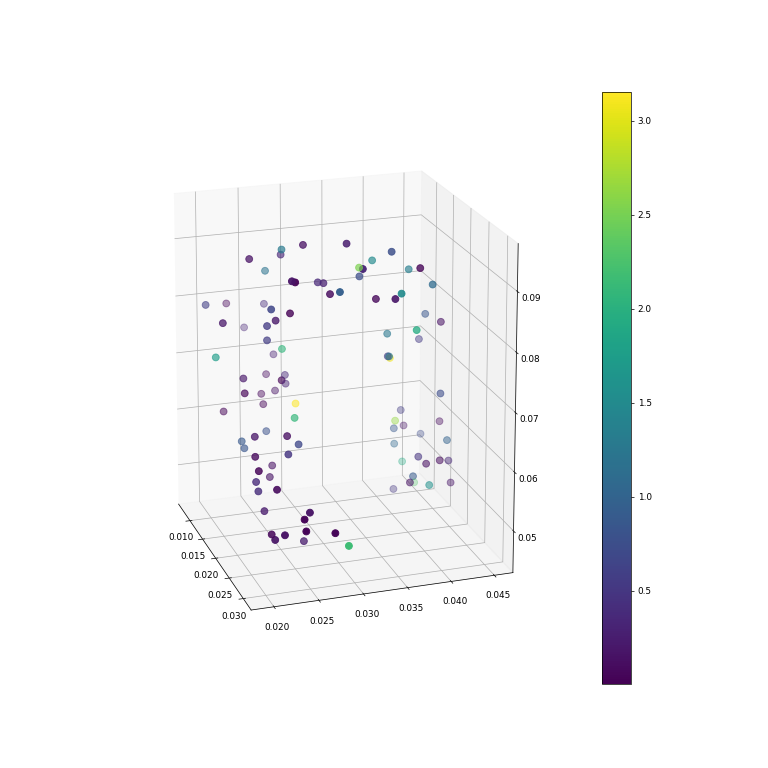

In [56]:
%matplotlib notebook
#select data to visualize
df_s = a.sample(100)
#df_s = df_abs.sample(1000)

# plot
fig=plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(df_s['X'], df_s['Y'], df_s['Z'], c=df_s['dotProduct'], s=60)
data_inc_colorMap = ax.scatter(df_s['X_SP'], df_s['Y_SP'], df_s['Z_SP'], c=df_s['Prediction error'], s=60)
#data_inc_colorMap = ax.scatter(df_s['X'], df_s['Y'], df_s['Z'], c=df_s['Prediction WSS'], s=60)
#data_inc_colorMap = ax.scatter(df_s['X'], df_s['Y'], df_s['Z'], c=df_s['wall_shear'], s=60)
ax.view_init(30, 185)
fig.colorbar(data_inc_colorMap)
plt.show()

In [54]:
t = df_s[df_s['Prediction error']>1]
t

,index,X_SP,Y_SP,Z_SP,wall_shear,Curvature,Torsion,Area,Prediction error,Prediction WSS,bumpy,AngularMetric
34825,74611,0.017383,0.037401,0.087517,26.070721,104.143996,2.333803,0.000357,1.364083,24.706638,0.003290,2.427880
32642,95380,0.023643,0.039098,0.082739,18.716251,39.466513,5.994424,0.000441,1.818540,16.897712,0.002927,-1.176167
22086,32358,0.014110,0.042189,0.052551,7.437618,25.525839,-209.289769,0.000352,1.442830,5.994788,0.003187,2.299745
2141,38579,0.018793,0.038045,0.077334,1.487452,28.856146,89.278933,0.000296,2.868584,4.356036,0.003173,-2.526217
32610,95563,0.016866,0.039779,0.084389,14.173121,39.466513,5.994424,0.000441,1.540132,15.713254,0.002924,2.297038
24096,8859,0.016343,0.020349,0.084778,3.305327,44.355401,-312.994363,0.000508,1.528348,4.833675,0.004190,-0.194983
37073,4337,0.029110,0.030921,0.048702,10.031860,0.110115,104.285665,0.001070,2.415889,12.447749,0.004345,-2.871289
41420,56786,0.016035,0.020522,0.076887,10.836575,63.318197,-46.456445,0.000511,1.209344,9.627231,0.004669,-0.984554
8808,47614,0.023131,0.037088,0.092524,6.999179,136.517139,-46.548180,0.000410,1.216819,8.215999,0.003547,0.435219
22462,34746,0.016397,0.045161,0.057722,12.638927,20.070351,123.396120,0.000317,1.205824,11.433103,0.003090,1.073490


AttributeError: 'Series' object has no attribute 'his'